<a href="https://www.kaggle.com/code/shashank069/gan-mode-collapse-and-ndb-score?scriptVersionId=109503890" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

The aim of this notebook is to train a simple GAN architecture, detect mode collapse, and compute NDB score to quantify mode collapse

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import os
np.random.seed(42)
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, Input
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint

# Config

In [2]:
class config:
    img_dir = "../input/art-portraits/Portraits/"
    batch_size = 32
    img_size = 64
    latent_dim = 100
    dropout = 0.2
    """
    arch : [filters,kernel_size,strides,padding,activation]
    """
    discrim_arch = [
    [32,3,2,'same'],
    [64,3,2,'same'],
    [128,3,2,'same'],
    [256,3,1,'same'],
    [512,3,1,'same']
]
    """
    arch : [reshape_size,activation]
    """
    reshape_layer = [(4,4,256),'relu']
    
    """
    arch : [filters,kernel_size,padding,activation]
    """
    
    generator_arch = [
    [256,3,'same'],
    [256,3,'same'],
    [256,3,'same'],
    [128,3,'same'],
    [3,3,'same']
]
    epochs = 300
    discriminator_lr = 1e-5
    generator_lr = 1e-5
    beta = 0.5

# Preprocessing

I've randomly plotted some images. The images vary in size, so I'll shrink them down to (64,64) to speed up model training.

In [3]:
print(f"Number of images = {len(os.listdir(config.img_dir))}")

Number of images = 4117


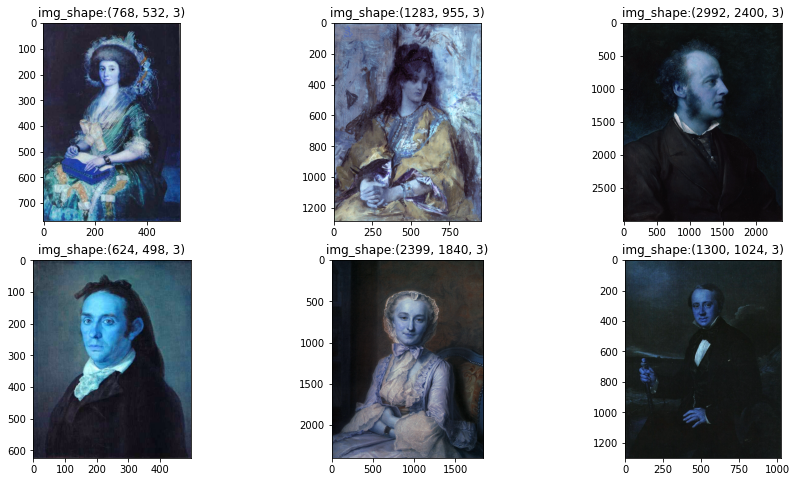

In [4]:
f,ax = plt.subplots(2,3,figsize=(15,8))
ax = ax.flatten()
for i,img_name in enumerate(os.listdir(config.img_dir)[100:106]):
    img = cv2.imread(f"{config.img_dir}/{img_name}",-1)
    ax[i].imshow(img)
    ax[i].set_title(f"img_shape:{img.shape}")

In [5]:
#Import as tf.Dataset
bs = int(config.batch_size/2)
portraits = tf.keras.preprocessing.image_dataset_from_directory(config.img_dir,label_mode=None ,image_size=(config.img_size,config.img_size), batch_size=bs).map(lambda x: x / 255.0)

Found 4117 files belonging to 1 classes.


2022-10-29 21:40:26.984049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:40:27.138116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:40:27.138988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 21:40:27.141612: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2022-10-29 21:40:29.875739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


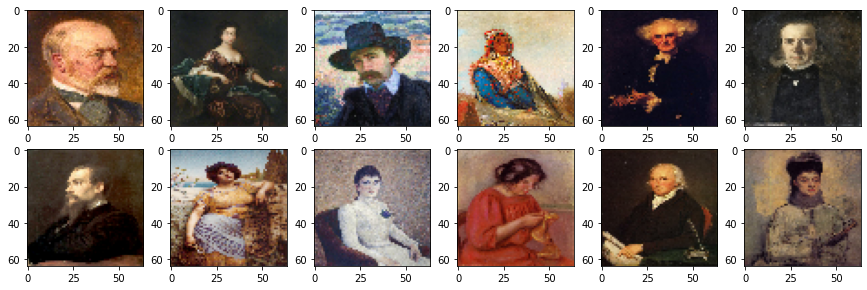

In [6]:
#Plotting reshape images from the keras dataset
plt.figure(figsize=(15,15))
for image_batch in portraits.take(1):
    for i in range(12):
        ax = plt.subplot(6, 6, i + 1)
        ax.imshow(image_batch[i].numpy())

# Generator

The generator accepts a random 1D array (I've chosen a length of 100). The first dense layer expands the input and the subsequent reshape layer transforms it to a 3D tensor. Next, the tensor goes down a fully convolutional network, made up of multiple convup_blocks, which produce an rgb image of size specified in config (I've taken 64). All convup_blocks, instead of the last one, consist of a convolutional layer and an upsampling layer. As the name suggests, the upsampling layer the doubles the dimensions of the input. However, unlike the transpose convolutional layer, its parameters are not learnable.

In [7]:
#Convup_block which includes a convolutional layer and an upsample
def convup_block(mod,activation=Activation('relu'),last=False,**kwargs):
    mod.add(Conv2D(**kwargs))
    if last==False:
        mod.add(BatchNormalization())
        mod.add(activation)
        mod.add(UpSampling2D())
    else:
        mod.add(activation)
    return mod

In [8]:
# Building the Generator
generator = Sequential()
generator.add(Dense(np.product(config.reshape_layer[0]),activation=config.reshape_layer[1],input_dim=config.latent_dim))
generator.add(Reshape(config.reshape_layer[0]))
for i in range(len(config.generator_arch)):
    layer = config.generator_arch[i]
    dic = {'filters': layer[0], 'kernel_size': layer[1], 
           'padding': layer[2]}
    if i == len(config.generator_arch)-1:
        generator = convup_block(generator,activation=Activation('sigmoid'),last=True,**dic)
    else:
        generator = convup_block(generator,activation=Activation('relu'),**dic)
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         5

When untrained, the generator will produce garbage output. Although post training, we expect it to paint portraits.

2022-10-29 21:40:36.490662: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


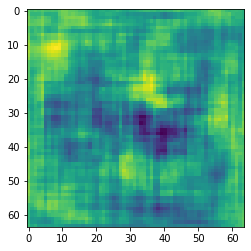

In [9]:
random_arr = tf.random.normal([1,config.latent_dim])
random_img = generator(random_arr,training=False)
plt.imshow(random_img[0,:,:,0])

# Discriminator

Generator's alter ego, the discriminator accepts an input image and identifies whether it's a real portrait. It consists of multiple convolutional blocks followed by a dense layer and functions like a typical CNN classfier. The final output is a score assgined based on whether the input seems real.

In [10]:
def conv_block(inp,activation,**kwargs):
    x = Conv2D(**kwargs)(inp)
    x = BatchNormalization()(x)
    x = activation(x)
    x = Dropout(config.dropout)(x)
    return x

In [11]:
inp_img = Input((config.img_size,config.img_size,3))
for i in range(len(config.discrim_arch)):
    layer = config.discrim_arch[i]
    dic = {'filters': layer[0], 'kernel_size': layer[1], 'strides': layer[2], 
           'padding': layer[3]}
    if i ==0:
        conv = conv_block(inp_img,activation=LeakyReLU(alpha=0.2),**dic)
    else:
        conv = conv_block(conv,activation=LeakyReLU(alpha=0.2),**dic)
fl = Flatten()(conv)
dense = Dense(1,activation='sigmoid')(fl)
discriminator = Model(inputs=inp_img,outputs=dense)
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 64)        256   

# GAN Training

GAN is the combination of the above defined generator and discriminator. The two are trained in isolation
Here's the training loop

### Discriminator training
1. Generator creates fake images from a random array of specified latent dimensions
2. The fake images are labelled as 0, while the real ones as 1
3. The two sets are combined and passed into the discriminator
4. Using the labels, the discriminator learns to differentiate b/w real and fake images

### Generator training
1. Generator again creates fake images from a random array of specified latent dimensions
2. These fake images are labelled as 1 to confuse the discriminator
3. The fake images are passed to the discriminator which judges how whether the images are close to reality
4. Based on the output scores, gradients are created to update generator weights to create better images and outplay the discriminator

During generator training phase, the discriminator's weights aren't updated and vice versa. This training loop continues for a number of epochs. Ideally, the GAN network is trained when the discrimnator gives an ouput of 0.5 regardless of the input image class. Basically, the quality of generated images improve to a point where the discriminator can't differentiate them from real images. However, due to a variety of reasons, this convergence is rarely, if ever, achieved.

In [12]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
#         self.discriminator = Model(self.discriminator.inputs,outputs=
#                                   self.discriminator.outputs+[self.discriminator.layers[-2].output])
#         self.mse = tf.keras.losses.MeanSquaredError()
        #self.inp = Input((config.img_size,config.img_size,3))

    def compile(self, discr_optimizer, genr_optimizer, loss):
        super(GAN, self).compile()
        self.discr_optimizer = discr_optimizer
        self.genr_optimizer = genr_optimizer
        self.loss = loss
        self.discr_loss = tf.keras.metrics.Mean(name="discr_loss")
        self.genr_loss = tf.keras.metrics.Mean(name="genr_loss")
        self.comb_loss = tf.keras.metrics.Mean(name='comb_loss')
    @property
    def metrics(self):
        return [self.discr_loss, self.genr_loss]

    def train_step(self, real_portraits):
        batch_size = tf.shape(real_portraits)[0]
        #Generate a random array for generator to generate images
        x_fake = tf.random.normal(shape=(batch_size, self.latent_dim))
        #Generate fake images
        fake_portraits = self.generator(x_fake)
        # Jumble fake and real portraits to train discriminator
        portraits = tf.concat([real_portraits, fake_portraits], axis=0)
        # Assign labels as 1 and 0 for real and fake portraits
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Discriminator training
        with tf.GradientTape() as tape:
            scores = self.discriminator(portraits)
            d_loss = self.loss(labels, scores)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discr_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        #Generate a random array for generator to generate images
        x_fake = tf.random.normal(shape=(2*batch_size, self.latent_dim))
        labels = tf.ones((2*batch_size,1))
        #scores,real_feature_vecs = self.discriminator(real_portraits)
        #real_feature_vecs = tf.reduce_mean(real_feature_vecs,axis=0)
        # Train the generator while not updating the discriminator
        with tf.GradientTape() as tape:
            #socres,fake_feature_vecs = self.discriminator(self.generator(x_fake))
            #fake_feature_vecs = tf.reduce_mean(fake_feature_vecs,axis=0)
            #g_loss = self.mse(real_feature_vecs,fake_feature_vecs)
            scores = self.discriminator(self.generator(x_fake))
            g_loss = self.loss(labels,scores)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.genr_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # Update metrics
        self.discr_loss.update_state(d_loss)
        self.genr_loss.update_state(g_loss)
        self.comb_loss.update_state(d_loss+g_loss)
        return {"discriminator_loss": self.discr_loss.result(), "generator_loss": self.genr_loss.result()}

Below, is a custom training loop for the GAN network. I've used keras subclassing to create the GAN network and train it. Keras subclassing provides incredible flexibility using which, one can build their own training methodologies.

In [13]:
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adam(config.discriminator_lr,beta_1=config.beta)
generator_opt = tf.keras.optimizers.Adam(config.generator_lr,beta_1=config.beta)
loss = tf.keras.losses.BinaryCrossentropy()
callbacks = [ModelCheckpoint('gan.hdf5',verbose=1,save_best_only=True,monitor='comb_loss')]
model = GAN(discriminator, generator, config.latent_dim)
model.compile(discriminator_opt, generator_opt, loss)
history = model.fit(portraits,epochs=1,callbacks=callbacks)

258/258 [==============================] - 54s 197ms/step - discriminator_loss: 0.6609 - generator_loss: 0.7090


# Evaluation

There are two chief problems associated with GAN training

1. Loss convergence - As the generator and discriminator attempt to outplay each other, the loss seldom converges. In the image plotted below, the generator loss shows a mildly erratic behaviour with no signs of convergence. Inability to achieve convergence leads to poor quality of generated images.

2. Mode collapse - After each iteration of discriminator training, the generator updates its weights to fool that particular discriminator. Now, if the discriminator gets stuck in a local minima, and the generator produces an output that fools it, we enter mode collapse. Since the discriminator stops improving, the generator also loses the incentive to search for alternative outputs and starts producing the same output (single/subset) in each iteration.

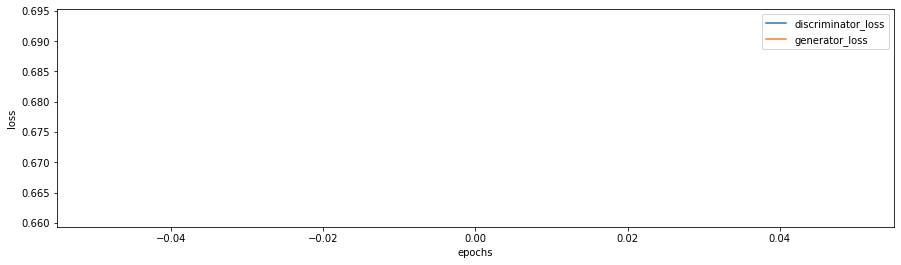

In [14]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
plt.plot(history_df['discriminator_loss'],label='discriminator_loss')
plt.plot(history_df['generator_loss'],label='generator_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

From the images below, it's clearly evident that the GAN has entered mode collapse. When working with small amount of images, one can identify mode collapse by plotting outputs. However, it's desirable to have measures to quantify mode collapse. We'll use k-means clustering to come with a metric.

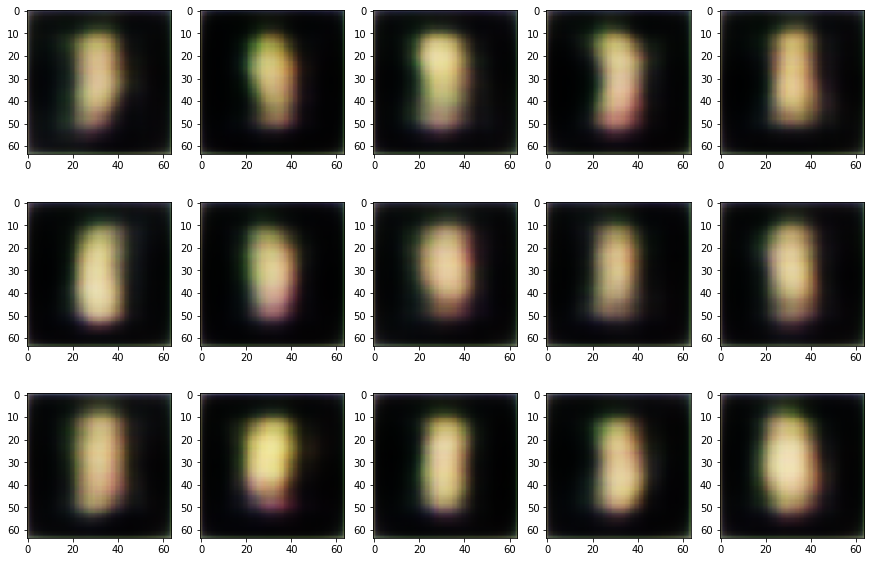

In [15]:
f,ax = plt.subplots(3,5,figsize=(15,10))
ax = ax.flatten()
arr = tf.random.normal(shape=(15, config.latent_dim))
generated_portraits = generator(arr)
for i in range(15):
    ax[i].imshow(generated_portraits[i])

In [16]:
from sklearn.cluster import KMeans

The first step is to cluster training images to find the optimal number of classes. This might not make sense on a qualitative level since all our images are portraits. Nevertheless, I expect the algorithm to identify subtle similarities amongst the portraits and create appropriate clusters. We'll iterate through our tf dataloader to create an array of all training images. We have rgb images of shape (64,64). To reduce dimensions, we'll average the arrays along the last axis to convert them to grayscale. Note that the actual formula for converting to grayscale is different. Refer this [link](https://e2eml.school/convert_rgb_to_grayscale.html) for more information. We can further shrink the dimensions using autoencoders/PCA, but I'll not for now. Finally, for clustering, we'll also flatten the images

In [17]:
images = []
training = tf.keras.preprocessing.image_dataset_from_directory(config.img_dir,label_mode=None ,image_size=(config.img_size,config.img_size), batch_size=1).map(lambda x: x / 255.0)
for i,batch in enumerate(training):
    if i == len(training):
        break
    else:
        images.append(np.array(batch[0]))

Found 4117 files belonging to 1 classes.


In [18]:
images = np.asarray(images)
images = np.mean(images,axis=3)
images = images.reshape((images.shape[0],-1))

To save computational time, I'll only use the first 100 images to create clusters

In [19]:
elbow_scores=[]
for c in range(4,10):
    kmeans = KMeans(c)
    kmeans.fit(images[:100])
    elbow_scores.append(kmeans.inertia_)

From the elbow score, it seems that we should use more clusters. This is expected as all images are of the same class(portraits) and hence the differences are subtle. Further reduction in image dimensionality might help create better clusters. However, I see a minor kink at 8 clusters, and for illustrative purposes, stick to it.

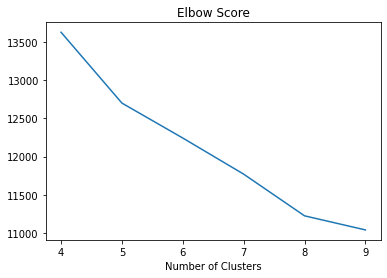

In [20]:
plt.plot(range(4,10),elbow_scores)
plt.xlabel('Number of Clusters')
plt.title('Elbow Score')
plt.show()

In [21]:
kmeans=KMeans(8)
train_classes=kmeans.fit_predict(images[:100])

Now,we'll generate 100 images from the generator, and see which clusters they fall into.

In [22]:
arr = tf.random.normal(shape=(100, config.latent_dim))
generated_portraits = generator(arr)

In [23]:
generated_portraits = np.array(generated_portraits).mean(axis=3).reshape((generated_portraits.shape[0],-1))

As, you can see all the generated portraits belong to the same cluster. Now, we'll expand this idea to create a more concrete statstical test.

In [24]:
generated_classes = kmeans.predict(generated_portraits)

# NDB Score

The ideal GAN should learn a probability distribution that closely mimics the training data distribution. This is quantified using [NDB score](https://arxiv.org/abs/1805.12462). Here's how its computed:

1. Cluster the training data (t samples) into 'n' bins (Like we have clustered the portraits into 8 bins)
2. Generate (g samples) of images
3. Predict the cluster(bin) of each generated image
4. For each bin do the following test:
    
    4.1 Compute the proportions of training and generated samples in that bin
    
    4.2 Divide their difference by the standard error SE which is calculated as shown below. Here 'p' and 'q' are used to refer training and generated data, and 'P' is the pooled sample proportion

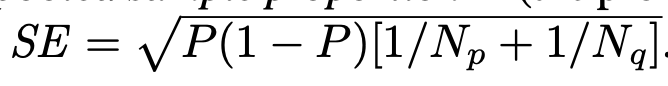
    
    4.3 If the p-value corresponding to the z-score is less than a threshold, the bin is deemed statistically different

5. Divide the number of statistically different bins by the number of bins. This'll give a number b/w 0 and 1 quantifying the difference between the real and learned distributions.
6. If '5' is greater than a set threshold, the GAN is deemed to have encountered mode collapse.

Please refer these links for more details:
1. https://www.google.com/search?q=ndb+score+gan&oq=ndb+&aqs=chrome.0.69i59j69i57j46i199i465i512j46i175i199i512j0i512j0i433i512j0i512j69i60.1083j0j7&sourceid=chrome&ie=UTF-8

2. https://arxiv.org/abs/1805.12462

In [25]:
def ndb_score(training_data_classes,generated_data_classes,num_classes,z_threshold):
    ndb = []
    NT = len(training_data_classes)
    NG = len(generated_data_classes)
    for i in range(num_classes):
        nt = np.sum(training_data_classes==i)
        pt = nt/len(training_data_classes) #training data proportion for bin
        ng = np.sum(generated_data_classes==i)
        pg = ng/len(generated_data_classes) #generated data proportion for bin
        P = (nt+ng)/(NT+NG)
        SE = (P*(1-P)*((1/NT)+(1/NG)))**0.5
        if abs((pt-pg)/SE) > z_threshold:
            ndb.append(i)
    print(f"Statisticall different classes:{ndb}")
    print(f"ndb score: {len(ndb)/num_classes}")

In [26]:
ndb_score(train_classes,generated_classes,8,1.96)

Statisticall different classes:[1, 2, 3, 4, 5, 6, 7]
ndb score: 0.875


For our case, we have a high ndb score indicative of mode collapse.

# CONCLUSION

NDB score could be an extremely handy metric to measure gan performance when working with big data. Here, like the paper, we have only used k-means clustering to create bins. However, as discussed, one could further reduce image dimensionality by running PCA on images or creating image feature vectors using autoencoders or intermediate CNN layers. Tuning hyperparamters could be one way to prevent mode collapse. But we have other options too. One could use a different loss function, or use unrolled GANs. I'll try to create a notebook on improving GAN performance next.

References:

1. https://www.google.com/search?q=ndb+score+gan&oq=ndb+&aqs=chrome.0.69i59j69i57j46i199i465i512j46i175i199i512j0i512j0i433i512j0i512j69i60.1083j0j7&sourceid=chrome&ie=UTF-8

2. https://arxiv.org/abs/1805.12462
3. https://www.kaggle.com/code/karnikakapoor/art-by-gan